In [2]:
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D 
import pandas as pd
import seaborn as sns
import sklearn as sk
from tqdm import tqdm

from april import Evaluator
from april.anomalydetection.utils import anomaly_ratio
from april.anomalydetection.utils import max_collapse
from april.enums import Axis
from april.fs import get_model_files
from april.utils import microsoft_colors

sns.set_style('white')
%config InlineBackend.figure_format = 'retina'

### Helper objects

In [2]:
synth_datasets = ['paper', 'p2p', 'small', 'medium', 'large', 'huge', 'gigantic', 'wide']
bpic_datasets = ['bpic12', 'bpic13', 'bpic15', 'bpic17']
datasets = synth_datasets + bpic_datasets

binet_ads = ["BINetv1", "BINetv2", "BINetv3"]
nn_ads = ["DAE"] + binet_ads
h_ads = nn_ads + [ "Likelihood+", "t-STIDE+", "Naive+"]
d_ads = ["Naive", "Sampling", "Likelihood"]
ads = h_ads + d_ads

strategies = [r'$\tau_{0}$', r'$\tau_{e}$', r'$\tau_{a}$', r'$\tau_{ea}$']
heuristics = [r'$h_{best}$', r'$h_{elbow\uparrow}$', r'$h_{elbow\downarrow}$', r'$h_{elbow\leftarrow}$', r'$h_{elbow\rightarrow}$', r'$h_{default}$']

In [3]:
models = [m for m in get_model_files()]

frames = []
for model in tqdm(models):
    evaluator = Evaluator(model)
    
    binarizer = evaluator.binarizer
    targets = binarizer.get_targets(axis=2)
    scores = binarizer.mask(evaluator.result.scores)
    
    for i, attribute_name in enumerate(evaluator.dataset.attribute_keys):
        for axis in [0, 1, 2]:
            _targets = max_collapse(targets[:, :, i], axis=axis).compressed()
            _scores = max_collapse(scores[:, :, i], axis=axis).compressed()
            auc = sk.metrics.roc_auc_score(_targets, _scores)
            fpr, tpr, thresholds = sk.metrics.roc_curve(_targets, _scores)
            frames.append(pd.DataFrame(dict(ad=evaluator.ad_.name,
                                            axis=axis,
                                            dataset_id=model.id,
                                            process_model=evaluator.process_model_name,
                                            event_log_name=evaluator.eventlog_name,
                                            attribute_name=attribute_name,
                                            level='cf' if i == 0 else 'data',
                                            dataset_type='bpic' if 'bpic' in evaluator.eventlog_name else 'synthetic',
                                            tpr=tpr, 
                                            fpr=fpr, 
                                            auc=auc)))
df = pd.concat(frames)

100%|██████████| 1137/1137 [10:55<00:00,  2.18s/it]


In [25]:
ads = ['BINetv0', 'BINetv1', 'BINetv2', 'BINetv3', 'DAE', 't-STIDE+', 'Naive', 'Likelihood', 'Sampling', 'OC-SVM', 'Random']

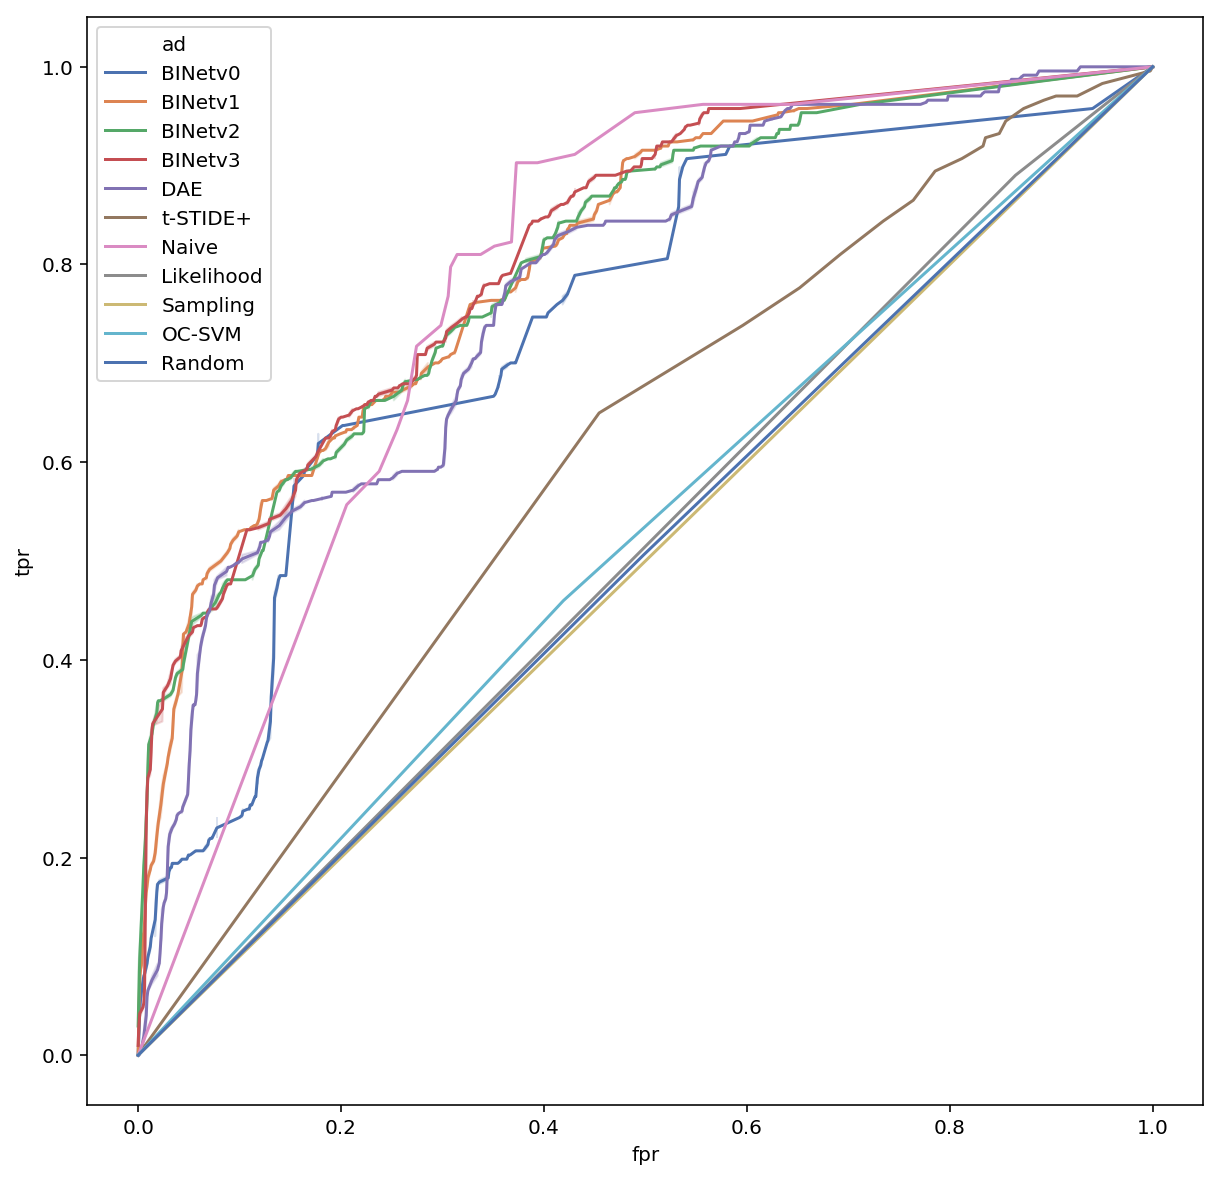

In [46]:
dff = df.query('process_model == "bpic13" and dataset_id == 1 and attribute_name == "name" and axis == 0')
g = plt.subplots(figsize=(10, 10))
g = sns.lineplot(data=dff, x='fpr', y='tpr', hue='ad', hue_order=ads, palette='deep')

## Evaluation on Synthetic and BPIC Datasets

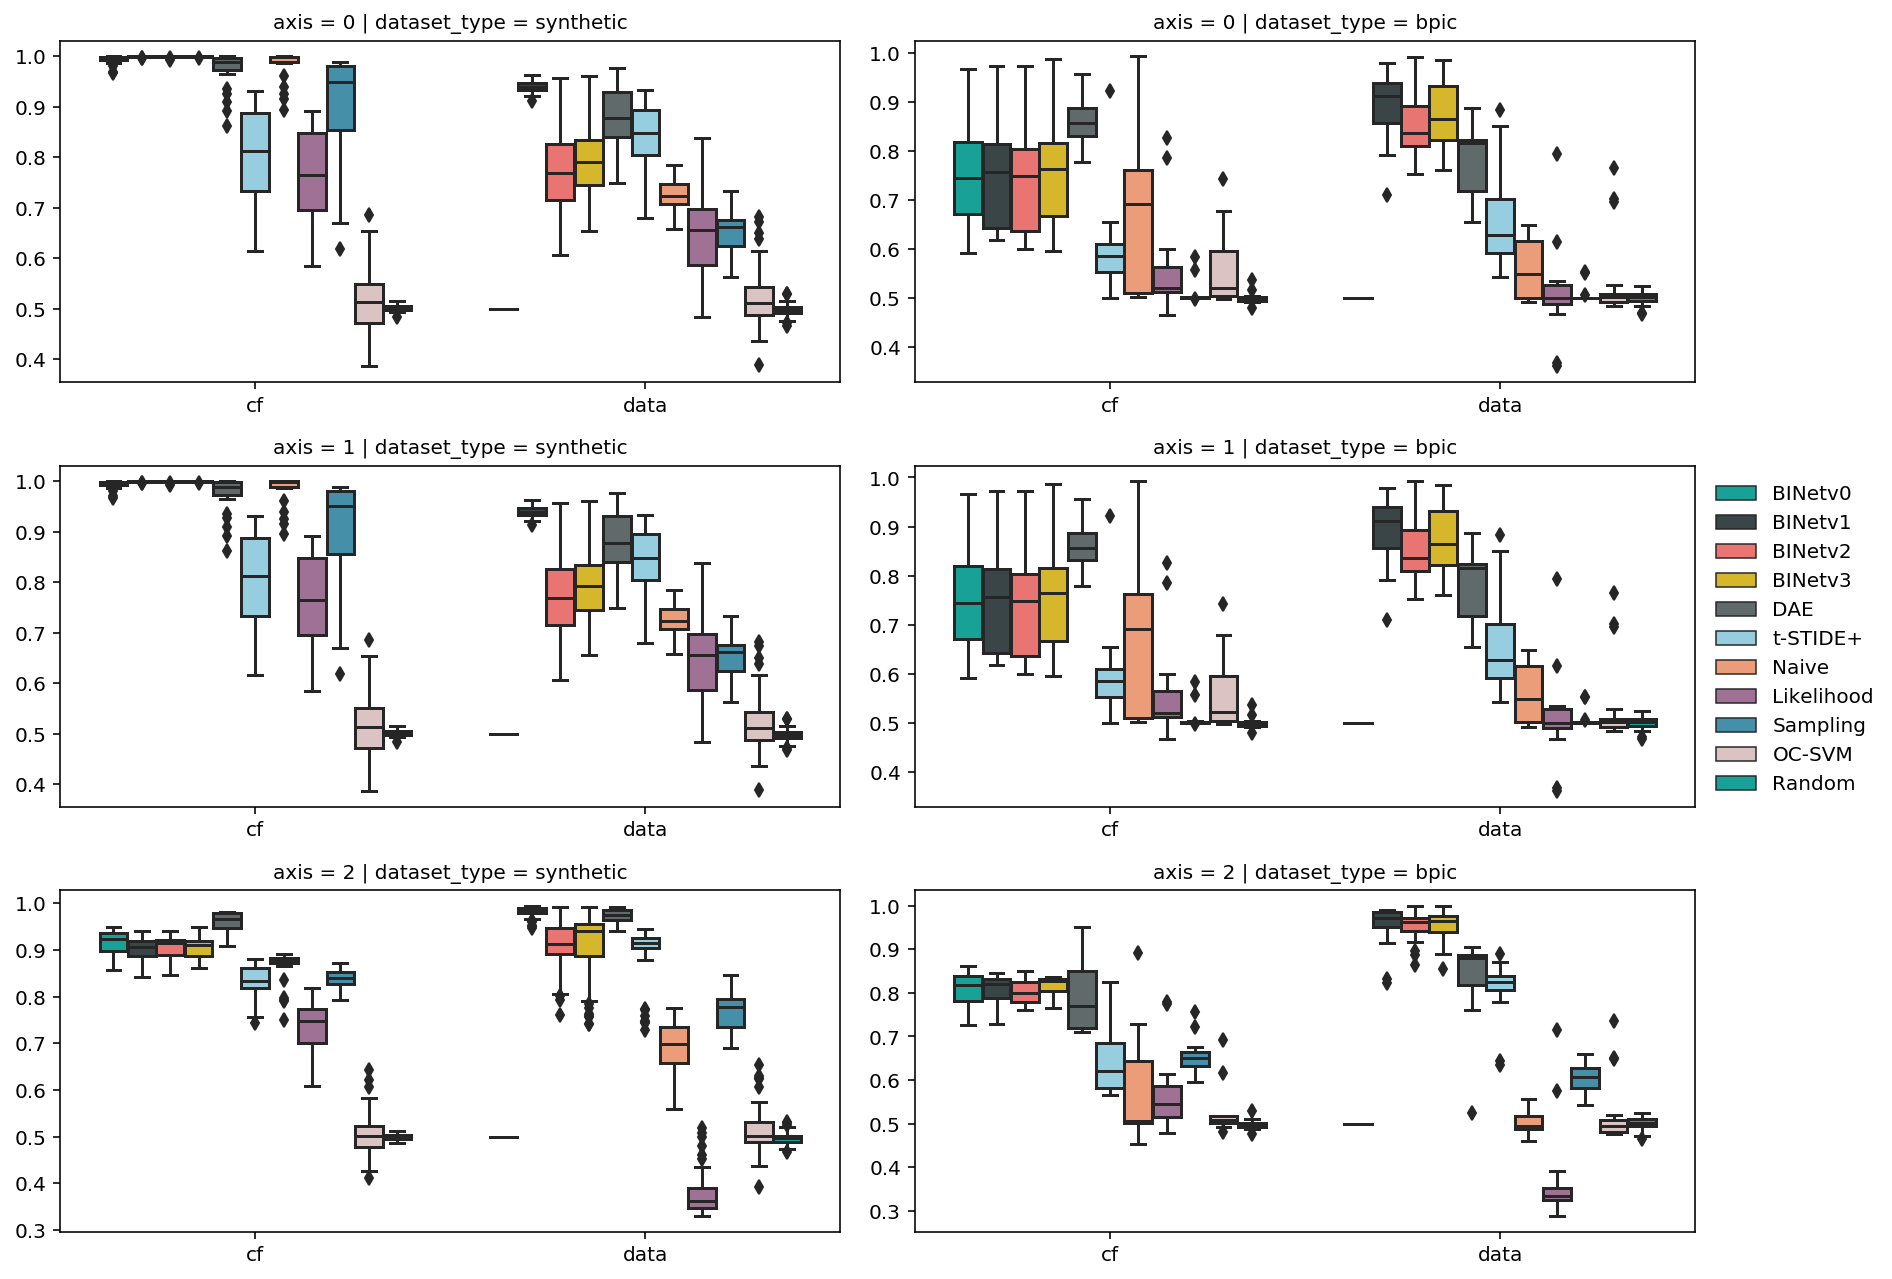

In [41]:
g = sns.FacetGrid(data=evaluation, col='dataset_type', row='axis', sharex=False, sharey=False, despine=False, aspect=2)
g = g.map_dataframe(sns.boxplot, x='level', y='auc', hue='ad', palette=microsoft_colors, hue_order=ads)
g = g.add_legend()

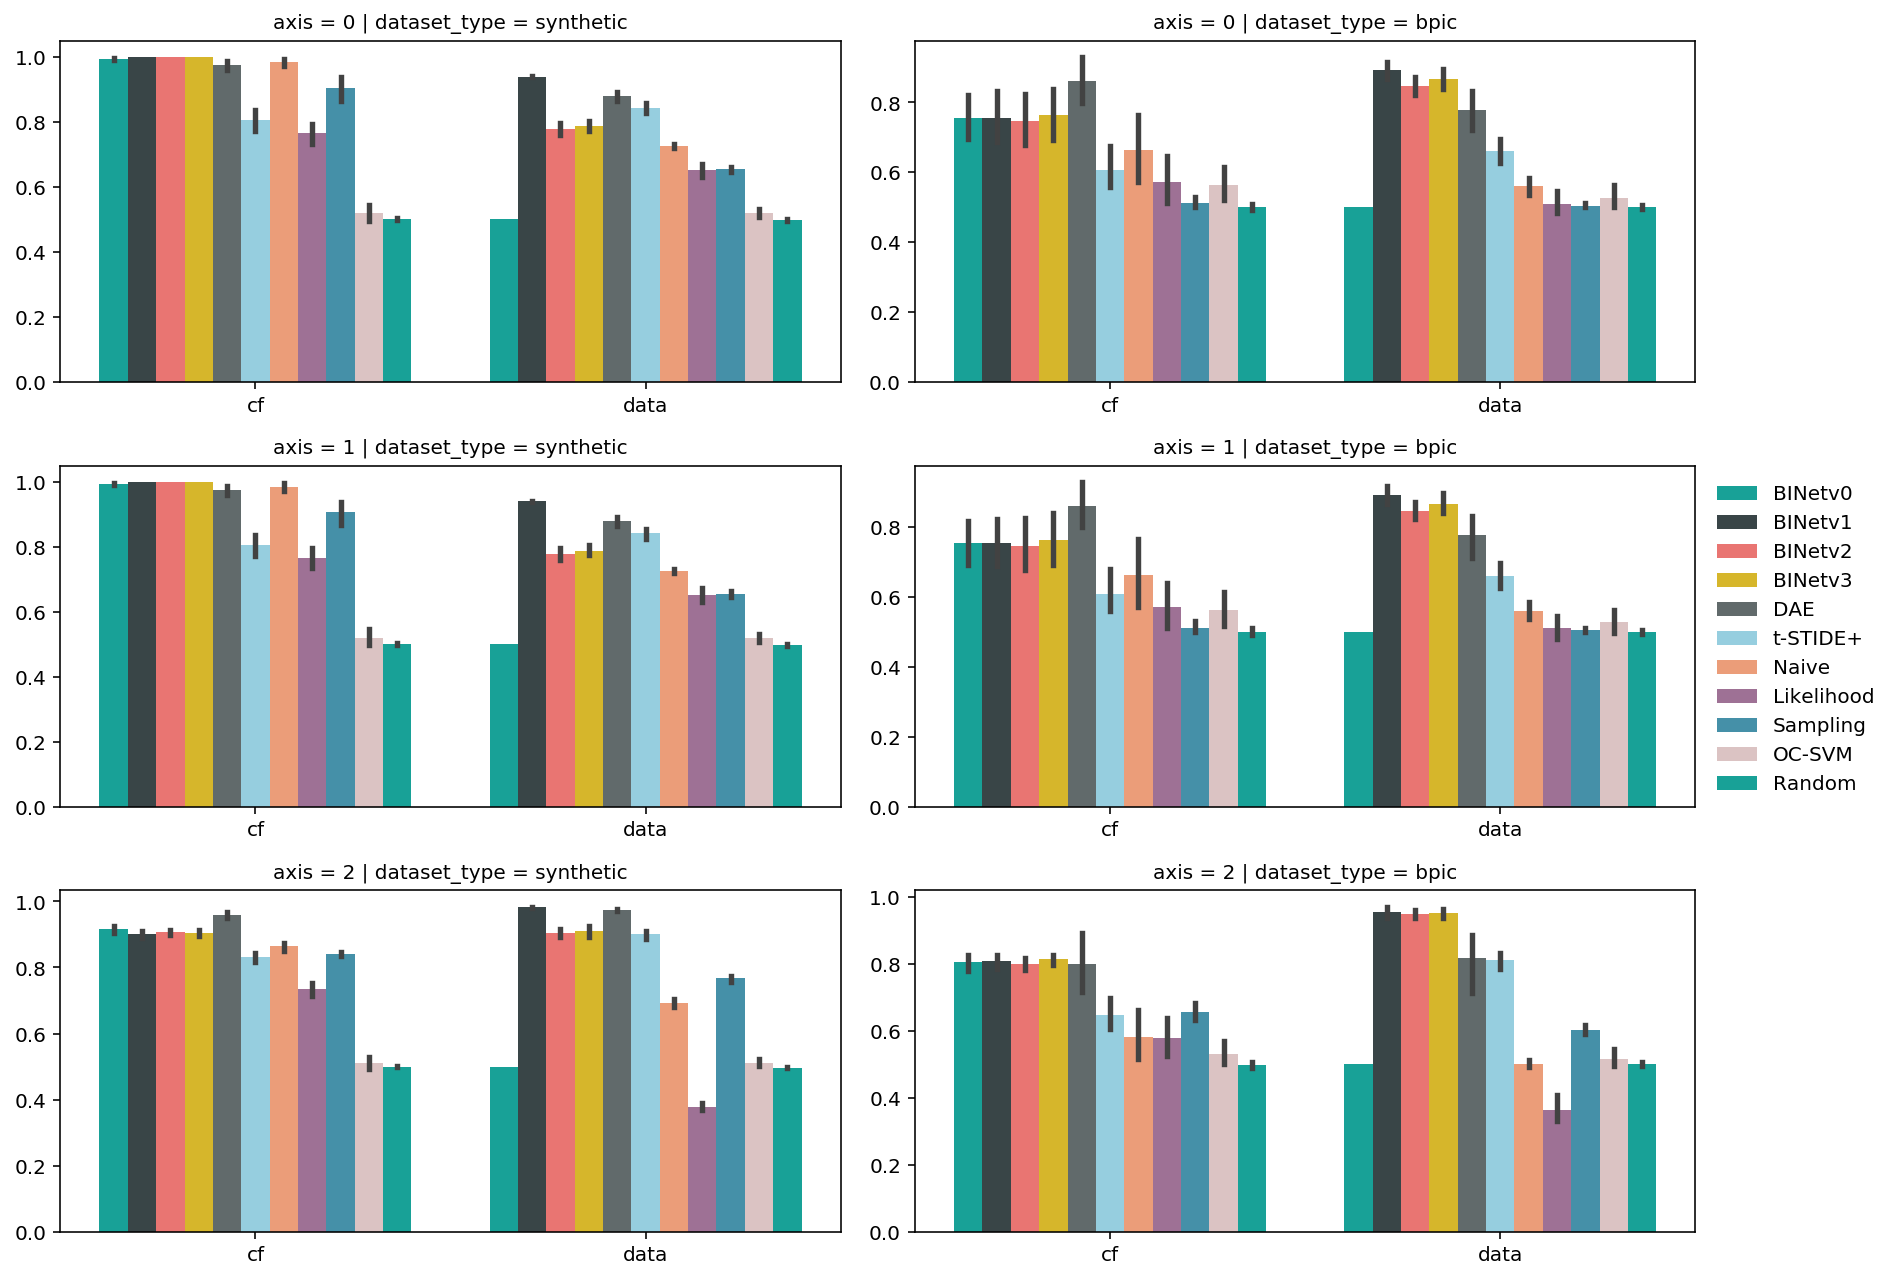

In [45]:
g = sns.FacetGrid(data=evaluation, col='dataset_type', row='axis', sharex=False, sharey=False, despine=False, aspect=2)
g = g.map_dataframe(sns.barplot, x='level', y='auc', hue='ad', palette=microsoft_colors, hue_order=ads)
g = g.add_legend()